In [1]:
import time
import torch
import numpy as np
import scipy.io

import matplotlib.pyplot as plt

from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch
import torch.nn as nn

In [2]:
torch.manual_seed(5527)
np.random.seed(5527)

In [3]:
# Physics-informed neural network - a straightforward MLP with tanh activations
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(PINN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_in = nn.Linear(input_size, hidden_size)
        self.linear_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_layers - 1)])
        self.linear_out = nn.Linear(hidden_size, 1)
        self.activ = nn.Tanh()
    
    def forward(self, x):
        x = self.linear_in(x)
        x = self.activ(x)
        for l in self.linear_hidden:
            x = l(x)
            x = self.activ(x)
        out = self.linear_out(x)
        return out

# Helper function to extract gradients of the NN outputs
def get_grads(u, x, t):
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]
    return u_t, u_x, u_xx

In [4]:
# User function specifying objective and constraints - required by PyGRANSO
def user_fn(model, sample_points, boundary_points, boundary_usol):
    # Forward pass for sample points
    x, t = sample_points
    xt = torch.cat((x, t), 1)
    u = model(xt)

    # Calculate gradients of network
    u_t, u_x, u_xx = get_grads(u, x, t)

    # Minimize residual
    res = u_t + u * u_x - 0.01 / np.pi * u_xx
#     f = torch.sqrt(torch.sum(res ** 2) / res.numel())
    f = torch.norm(res)

    xb, tb = boundary_points
    xtb = torch.cat((xb, tb), 1)
    ub = model(xtb)
    
    # No inequality constraints
    ci = pygransoStruct()
    
    # Constraint folding
#     ci.c1 = torch.sqrt(torch.sum((ub - boundary_usol) ** 2) / ub.numel())
    ci.c1 = torch.norm(ub - boundary_usol)

    # Equality constraint on boundary points
    ce = pygransoStruct()
    
#     ce.c1 = ub - boundary_usol
    ce = None

    return [f,ci,ce]



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

 420 ║ 0.019395 │  0.10846331937 ║  5.27122628498 ║ 0.006225 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.020239   ║ 
 430 ║ 0.019395 │  0.10372693171 ║  4.99631135264 ║ 0.006821 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.020915   ║ 
 440 ║ 0.019395 │  0.09638586962 ║  4.62856516830 ║ 0.006613 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.025259   ║ 
 450 ║ 0.019395 │  0.09139429385 ║  4.39902743329 ║ 0.006073 │   -  ║ S  │     2 │ 0.500000 ║     1 │ 0.024910   ║ 
 460 ║ 0.019395 │  0.08774040286 ║  4.21873397168 ║ 0.005916 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.016796   ║ 
 470 ║ 0.019395 │  0.08421375001 ║  4.06618581770 ║ 0.005348 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.008361   ║ 
 480 ║ 0.019395 │  0.08170930033 ║  3.94962893332 ║ 0.005104 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.019114   ║ 
 490 ║ 0.019395 │  0.07672145376 ║  3.67566228603 ║ 0.005430 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.008063   ║ 
 500 ║ 0.015710 │  0.06019810776 ║  3.46789251739 ║ 0.005716 │   -  ║ S 

1020 ║ 0.006763 │  0.00521010375 ║  0.70260804180 ║ 4.59e-04 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.008539   ║ 
1030 ║ 0.006763 │  0.00510960316 ║  0.68947127791 ║ 4.47e-04 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.004449   ║ 
1040 ║ 0.006763 │  0.00502304650 ║  0.67761422239 ║ 4.40e-04 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.002793   ║ 
1050 ║ 0.006763 │  0.00492007950 ║  0.66047160084 ║ 4.53e-04 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.006425   ║ 
1060 ║ 0.006087 │  0.00437804446 ║  0.64510205499 ║ 4.52e-04 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.005860   ║ 
1070 ║ 0.006087 │  0.00428103525 ║  0.63142340267 ║ 4.38e-04 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.011986   ║ 
1080 ║ 0.006087 │  0.00417378509 ║  0.61869725322 ║ 4.08e-04 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.008619   ║ 
1090 ║ 0.005478 │  0.00374984051 ║  0.61165940123 ║ 3.99e-04 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.003133   ║ 
1100 ║ 0.005478 │  0.00368416727 ║  0.60345277168 ║ 3.79e-04 │   -  ║ S 

1620 ║ 0.002122 │  7.5681052e-04 ║  0.31232495123 ║ 9.40e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.006336   ║ 
1630 ║ 0.002122 │  7.3817731e-04 ║  0.30370543122 ║ 9.36e-05 │   -  ║ S  │     2 │ 0.500000 ║     1 │ 0.009750   ║ 
1640 ║ 0.002122 │  7.2879432e-04 ║  0.30070813781 ║ 9.06e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.004163   ║ 
1650 ║ 0.002122 │  7.2330318e-04 ║  0.29939421804 ║ 8.79e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.001745   ║ 
1660 ║ 0.002122 │  7.1772211e-04 ║  0.29903558746 ║ 8.31e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.003050   ║ 
1670 ║ 0.002122 │  7.1349568e-04 ║  0.29818077807 ║ 8.07e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.009104   ║ 
1680 ║ 0.002122 │  7.0664434e-04 ║  0.29578518753 ║ 7.89e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.004324   ║ 
1690 ║ 0.002122 │  6.9861408e-04 ║  0.29339677494 ║ 7.60e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.005755   ║ 
1700 ║ 0.002122 │  6.9036862e-04 ║  0.29019594538 ║ 7.45e-05 │   -  ║ S 

2220 ║ 0.001392 │  3.1633001e-04 ║  0.21472642284 ║ 1.73e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 7.96e-04   ║ 
2230 ║ 0.001392 │  3.1397895e-04 ║  0.21363596436 ║ 1.65e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.003657   ║ 
2240 ║ 0.001392 │  3.1123848e-04 ║  0.21232217677 ║ 1.56e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.004705   ║ 
2250 ║ 0.001392 │  3.0894481e-04 ║  0.21102692819 ║ 1.51e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.002797   ║ 
2260 ║ 0.001392 │  3.0689911e-04 ║  0.20976013295 ║ 1.48e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.001704   ║ 
2270 ║ 0.001392 │  3.0534723e-04 ║  0.20894494367 ║ 1.44e-05 │   -  ║ S  │     2 │ 0.500000 ║     1 │ 9.90e-04   ║ 
2280 ║ 0.001392 │  3.0401007e-04 ║  0.20767156713 ║ 1.48e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.007303   ║ 
2290 ║ 0.001392 │  3.0133175e-04 ║  0.20626270351 ║ 1.41e-05 │   -  ║ S  │     2 │ 0.500000 ║     1 │ 9.22e-04   ║ 
2300 ║ 0.001392 │  2.9913451e-04 ║  0.20529767545 ║ 1.33e-05 │   -  ║ S 

2820 ║ 4.37e-04 │  8.0655877e-05 ║  0.16390842176 ║ 9.04e-06 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.001040   ║ 
2830 ║ 4.37e-04 │  8.0370896e-05 ║  0.16338587776 ║ 8.98e-06 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.001069   ║ 
2840 ║ 4.37e-04 │  8.0125595e-05 ║  0.16298086311 ║ 8.91e-06 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 4.39e-04   ║ 
2850 ║ 4.37e-04 │  7.9918789e-05 ║  0.16259588362 ║ 8.87e-06 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 3.32e-04   ║ 
2860 ║ 4.37e-04 │  7.9715806e-05 ║  0.16230891932 ║ 8.80e-06 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 3.36e-04   ║ 
2870 ║ 4.37e-04 │  7.9576749e-05 ║  0.16199487958 ║ 8.79e-06 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 4.21e-04   ║ 
2880 ║ 4.37e-04 │  7.9434476e-05 ║  0.16165361339 ║ 8.80e-06 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 2.22e-04   ║ 
2890 ║ 4.37e-04 │  7.9220000e-05 ║  0.16131658032 ║ 8.73e-06 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 9.79e-04   ║ 
2900 ║ 4.37e-04 │  7.8901985e-05 ║  0.16076521892 ║ 8.66e-06 │   -  ║ S 

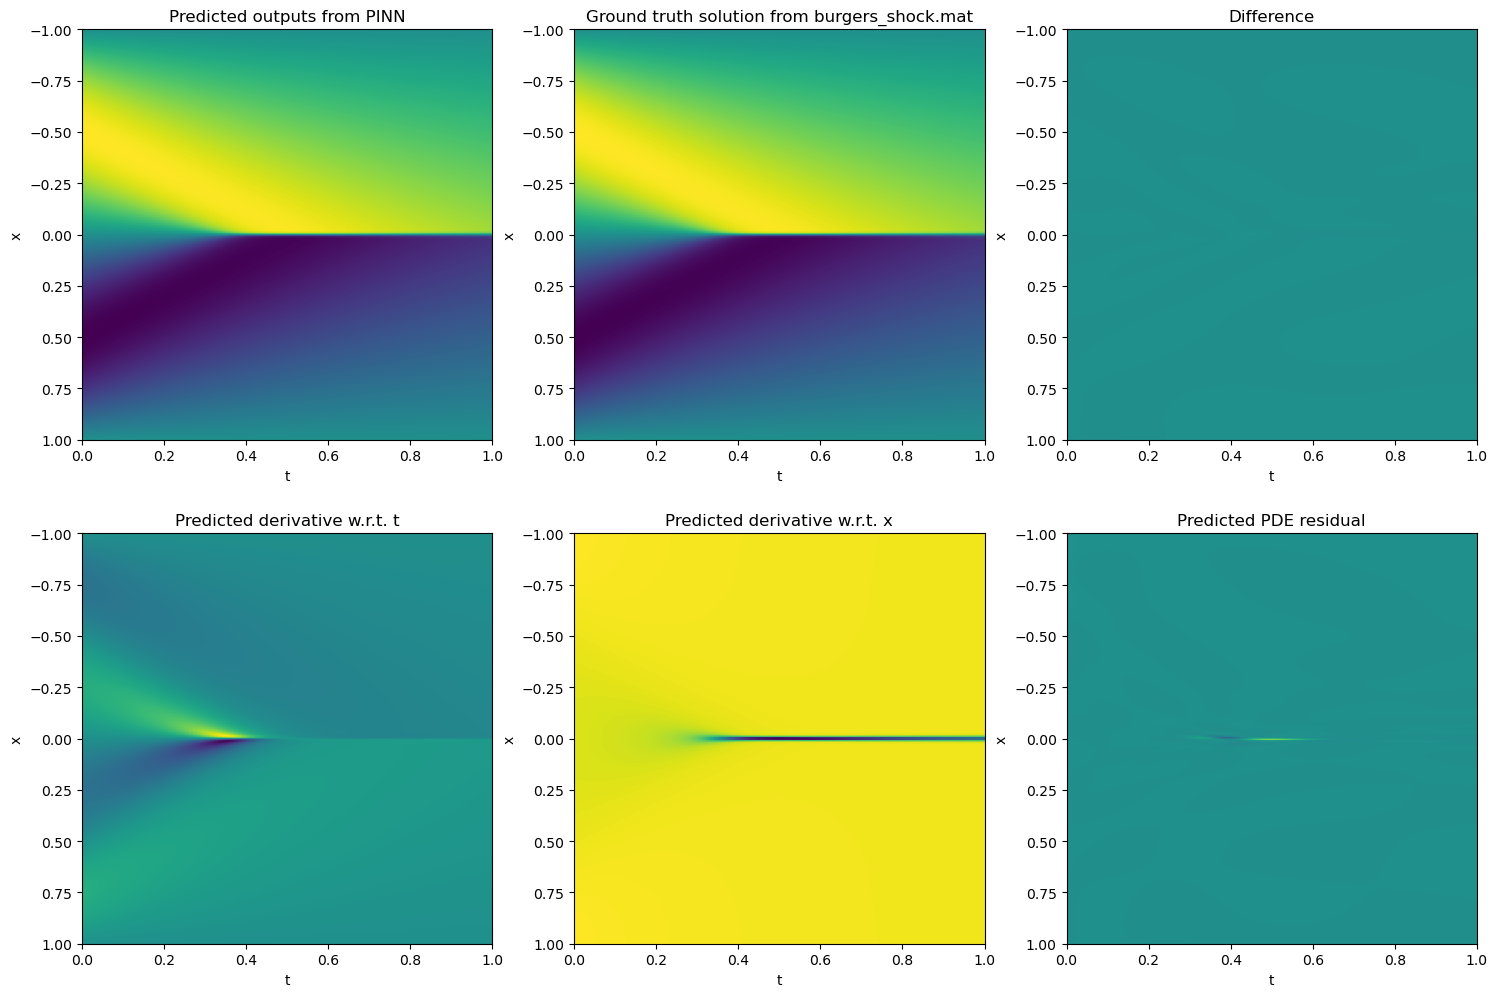

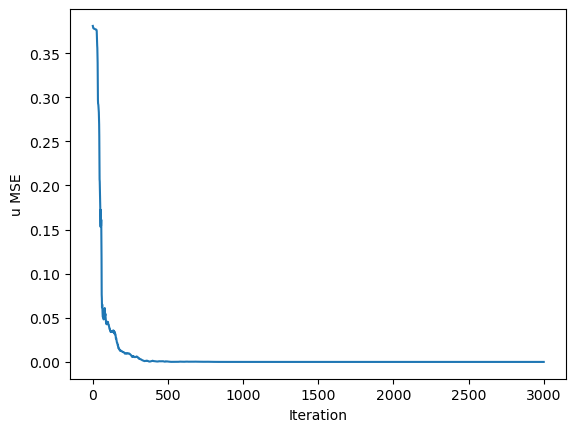

In [5]:
# Evaluates the relative L2 error over all grid points
# Notably, this is NOT what the PINN is minimizing--it only has access to boundary points
def evaluate(iteration, model, xv, tv, test_usol, error):
    test_points = torch.stack((xv, tv)).transpose(0,1)
    pred_usol = model(test_points)
    L2_error = torch.norm(pred_usol.flatten() - test_usol) ** 2 / pred_usol.numel()
    error[iteration-1] = L2_error.cpu().detach().item()

    # Save intermediate results (NN outputs + PDE residuals) as images
    if iteration % 25 == 0:
        outimg = pred_usol.cpu().detach().numpy()
        outimg = np.reshape(outimg, (xgridsize, tgridsize))
        plt.imsave("output_imgs/predicted_"+str(iteration)+".png", outimg, origin='upper')
        plt.close()
        evalu_t, evalu_x, evalu_xx = get_grads(pred_usol, xv, tv)
        evalres = evalu_t + torch.flatten(pred_usol) * evalu_x - 0.01 / np.pi * evalu_xx
        outimg = evalres.cpu().detach().numpy()
        outimg = np.reshape(outimg, (xgridsize, tgridsize))
        plt.imsave("output_imgs/pderesidual_"+str(iteration)+".png", outimg, vmin=-3, vmax=3, origin='upper')
        plt.close()


if __name__ == "__main__":
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
#     device = torch.device("cpu")
    double_precision = torch.double
#     double_precision = torch.float
    torch.manual_seed(0)

    # NN hyperparams - width + depth are somewhat arbitrary and vary between papers
    input_size = 2
    hidden_size = 20
    num_layers = 7

    data = scipy.io.loadmat('./data/burgers_shock.mat')

    # Create PINN
    model = PINN(input_size, hidden_size, num_layers).to(device=device, dtype=double_precision)
    model.train()

    # Get boundary points along three sides (x = -1, x = 1, t = 0)
    tb_x = data['t']
    xb_t = data['x']
    xb_xlow = np.full_like(tb_x, data['x'][0])
    xb_xhigh = np.full_like(tb_x, data['x'][-1])
    tb_tlow = np.full_like(xb_t, data['t'][0])

    usol_xlow = data['usol'][0,:,None]
    usol_xhigh = data['usol'][-1,:,None]
    usol_tlow = data['usol'][:,0,None]

    xb = np.vstack((xb_xlow, xb_xhigh, xb_t))
    tb = np.vstack((tb_x, tb_x, tb_tlow))
    usolb = np.vstack((usol_xlow, usol_xhigh, usol_tlow))

    xb = torch.Tensor(xb).to(device=device, dtype=double_precision).requires_grad_()
    tb = torch.Tensor(tb).to(device=device, dtype=double_precision).requires_grad_()
    usolb = torch.Tensor(usolb).to(device=device, dtype=double_precision).requires_grad_()
    boundary_points = (xb, tb)

    # Ground-truth data - used for testing/evaluation
    usol_full = data['usol']
    usol_tensor = usol_full.flatten()
    usol_tensor = torch.Tensor(usol_tensor).to(device=device, dtype=double_precision)

    # Sample points. Following Dual-Cone Gradient Descent, 10x as many sample points as boundary points
    n_samples = 4560
    xs = -1 + 2 * np.random.rand(n_samples, 1)
    ts = np.random.rand(n_samples, 1)

    xs = torch.Tensor(xs).to(device=device, dtype=double_precision).requires_grad_()
    ts = torch.Tensor(ts).to(device=device, dtype=double_precision).requires_grad_()
    sample_points = (xs, ts)

    # Create grid inputs for visualization, comparison to GT
    xgridsize = 256
    tgridsize = 100
    tv, xv = np.meshgrid(data['t'], data['x'])
    tv = torch.Tensor(tv.flatten()).to(device=device, dtype=double_precision).requires_grad_()
    xv = torch.Tensor(xv.flatten()).to(device=device, dtype=double_precision).requires_grad_()
    grid_points = torch.stack((xv, tv)).transpose(0,1)

    # Tensors have fixed size and we need to modify in-place, so initialize with maximum possible size
    max_iters = 3000
    error = torch.empty(max_iters, device=device, dtype=double_precision)

    # Functions for optimizer
    comb_fn = lambda model: user_fn(model, sample_points, boundary_points, usolb)
    halt_log_fn = lambda iteration, x, penaltyfn_parts, d,get_BFGS_state_fn, H_regularized, ls_evals, alpha, n_gradients, stat_vec, stat_val, fallback_level: \
        evaluate(iteration, model, xv, tv, usol_tensor, error)

    # Pygranso Options
    opts = pygransoStruct()
    nvar = getNvarTorch(model.parameters())
    opts.x0 = nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
    opts.torch_device = device
    opts.double_precision = True
    opts.print_level = 1
    opts.print_frequency = 10
    opts.disable_terminationcode_6 = True # Important for training NNs
    opts.maxit = max_iters
    opts.halt_log_fn = halt_log_fn

    # Hyperparameters
    opts.mu0 = 2

    # Main algorithm
    start = time.time()
    soln = pygranso(var_spec= model, combined_fn = comb_fn, user_opts = opts)
    end = time.time()
    print("Total Wall Time: {}s".format(end - start))

    model.eval()

    test_output = model(grid_points)

    # Plot predictions, GT, and error over the full range
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 12))
    outimg = test_output.cpu().detach().numpy()
    outimg = np.reshape(outimg, (xgridsize, tgridsize))

    global_min = np.min([np.min(outimg), np.min(usol_full), np.min(np.abs(outimg - usol_full))])
    global_max = np.max([np.max(outimg), np.max(usol_full), np.max(np.abs(outimg - usol_full))])

    ax1.set_title("Predicted outputs from PINN")
    ax1.set_xlabel("t")
    ax1.set_ylabel("x")
    ax1.set_box_aspect(1)
    ax1.imshow(outimg, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')

    ax2.set_title("Ground truth solution from burgers_shock.mat")
    ax2.set_xlabel("t")
    ax2.set_ylabel("x")
    ax2.set_box_aspect(1)
    ax2.imshow(usol_full, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')

    ax3.set_title("Difference")
    ax3.set_xlabel("t")
    ax3.set_ylabel("x")
    ax3.set_box_aspect(1)
    ax3.imshow(usol_full - outimg, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')

    # Calculate gradients of network
    testu_t, testu_x, testu_xx = get_grads(test_output, xv, tv)

    testres = testu_t + torch.flatten(test_output) * testu_x - 0.01 / np.pi * testu_xx

    test_ut_img = testu_t.cpu().detach().numpy()
    test_ut_img = np.reshape(test_ut_img, (xgridsize, tgridsize))
    test_ux_img = testu_x.cpu().detach().numpy()
    test_ux_img = np.reshape(test_ux_img, (xgridsize, tgridsize))
    test_res_img = testres.cpu().detach().numpy()
    test_res_img = np.reshape(test_res_img, (xgridsize, tgridsize))

    ax4.set_title("Predicted derivative w.r.t. t")
    ax4.set_xlabel("t")
    ax4.set_ylabel("x")
    ax4.set_box_aspect(1)
    ax4.imshow(test_ut_img, extent=[0, 1, 1, -1], aspect='auto')

    ax5.set_title("Predicted derivative w.r.t. x")
    ax5.set_xlabel("t")
    ax5.set_ylabel("x")
    ax5.set_box_aspect(1)
    ax5.imshow(test_ux_img, extent=[0, 1, 1, -1], aspect='auto')

    ax6.set_title("Predicted PDE residual")
    ax6.set_xlabel("t")
    ax6.set_ylabel("x")
    ax6.set_box_aspect(1)
    ax6.imshow(test_res_img, vmin=-1, vmax=1, extent=[0, 1, 1, -1], aspect='auto')
    plt.show()

    # Plot L2 loss over full grid
    iter_range = np.arange(1, soln.iters+1)
    error = error.detach().cpu().numpy()
    plt.plot(iter_range, error[:soln.iters])
    plt.xlabel("Iteration")
    plt.ylabel("u MSE")
    plt.show()


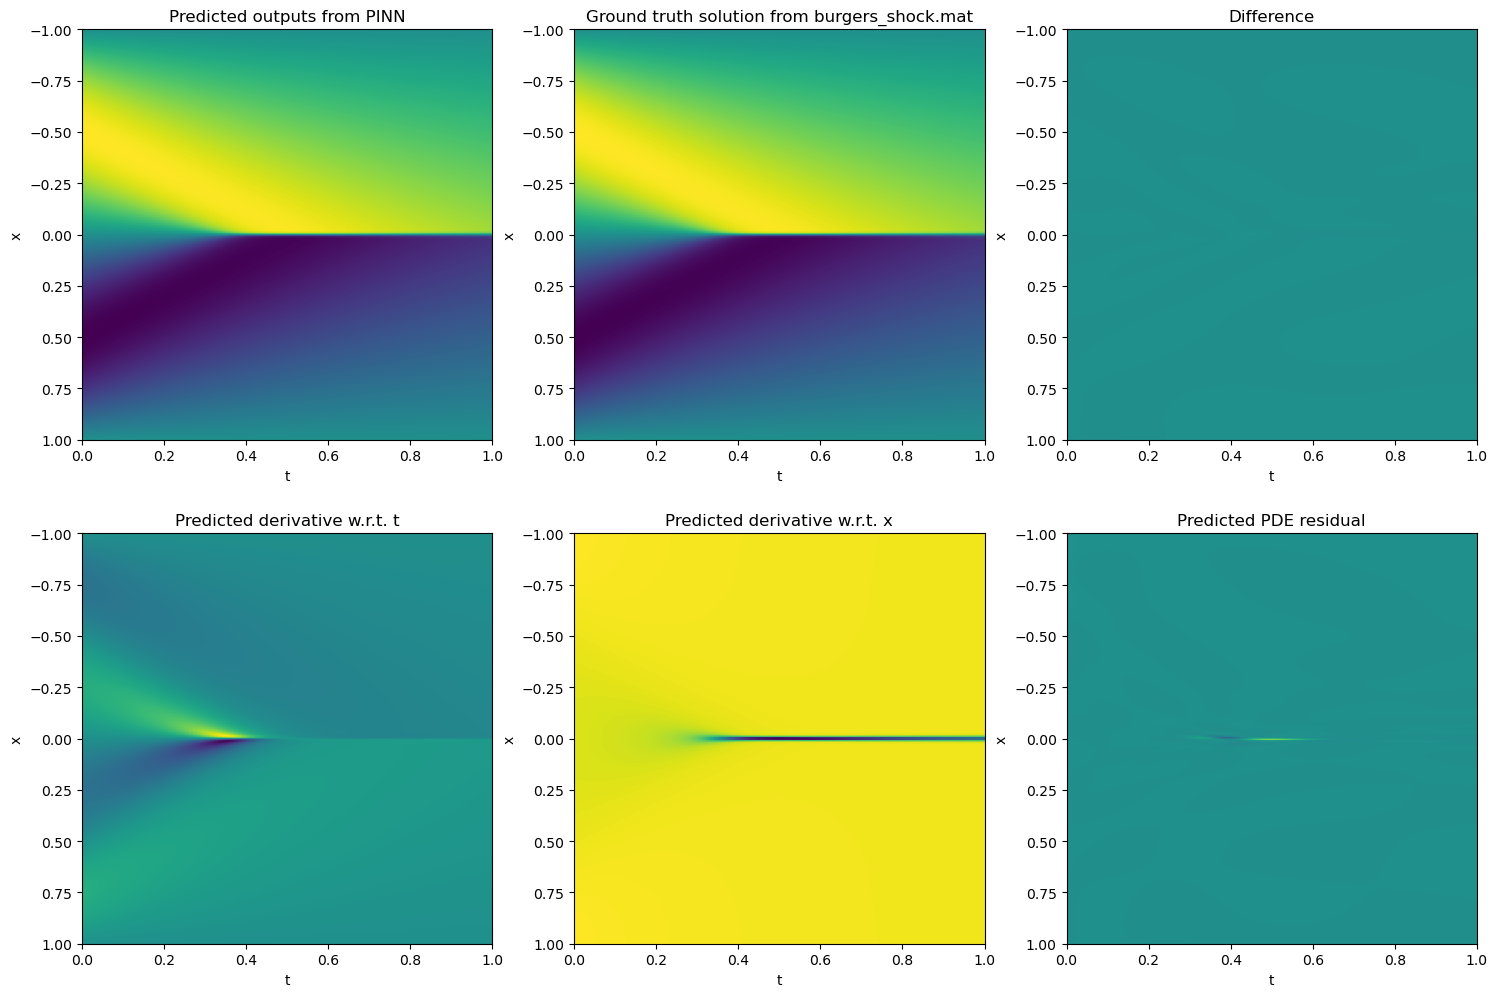

In [6]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(18, 12))
outimg = test_output.cpu().detach().numpy()
outimg = np.reshape(outimg, (xgridsize, tgridsize))

global_min = np.min([np.min(outimg), np.min(usol_full), np.min(np.abs(outimg - usol_full))])
global_max = np.max([np.max(outimg), np.max(usol_full), np.max(np.abs(outimg - usol_full))])

ax1.set_title("Predicted outputs from PINN")
ax1.set_xlabel("t")
ax1.set_ylabel("x")
ax1.set_box_aspect(1)
ax1.imshow(outimg, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')

ax2.set_title("Ground truth solution from burgers_shock.mat")
ax2.set_xlabel("t")
ax2.set_ylabel("x")
ax2.set_box_aspect(1)
ax2.imshow(usol_full, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')

ax3.set_title("Difference")
ax3.set_xlabel("t")
ax3.set_ylabel("x")
ax3.set_box_aspect(1)
ax3.imshow(usol_full - outimg, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')

# Calculate gradients of network
testu_t, testu_x, testu_xx = get_grads(test_output, xv, tv)

testres = testu_t + torch.flatten(test_output) * testu_x - 0.01 / np.pi * testu_xx

test_ut_img = testu_t.cpu().detach().numpy()
test_ut_img = np.reshape(test_ut_img, (xgridsize, tgridsize))
test_ux_img = testu_x.cpu().detach().numpy()
test_ux_img = np.reshape(test_ux_img, (xgridsize, tgridsize))
test_res_img = testres.cpu().detach().numpy()
test_res_img = np.reshape(test_res_img, (xgridsize, tgridsize))

ax4.set_title("Predicted derivative w.r.t. t")
ax4.set_xlabel("t")
ax4.set_ylabel("x")
ax4.set_box_aspect(1)
ax4.imshow(test_ut_img, extent=[0, 1, 1, -1], aspect='auto')

ax5.set_title("Predicted derivative w.r.t. x")
ax5.set_xlabel("t")
ax5.set_ylabel("x")
ax5.set_box_aspect(1)
ax5.imshow(test_ux_img, extent=[0, 1, 1, -1], aspect='auto')

ax6.set_title("Predicted PDE residual")
ax6.set_xlabel("t")
ax6.set_ylabel("x")
ax6.set_box_aspect(1)
ax6.imshow(test_res_img, vmin=-1, vmax=1, extent=[0, 1, 1, -1], aspect='auto')
plt.show()

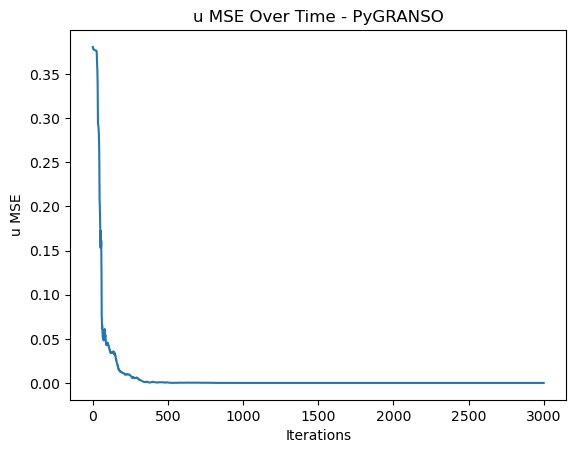

In [7]:
# Plot L2 loss over full grid
iter_range = np.arange(1, soln.iters+1)
plt.plot(iter_range, error[:soln.iters])
plt.xlabel("Iterations")
plt.ylabel("u MSE")
plt.title("u MSE Over Time - PyGRANSO")
plt.show()

### Training Points

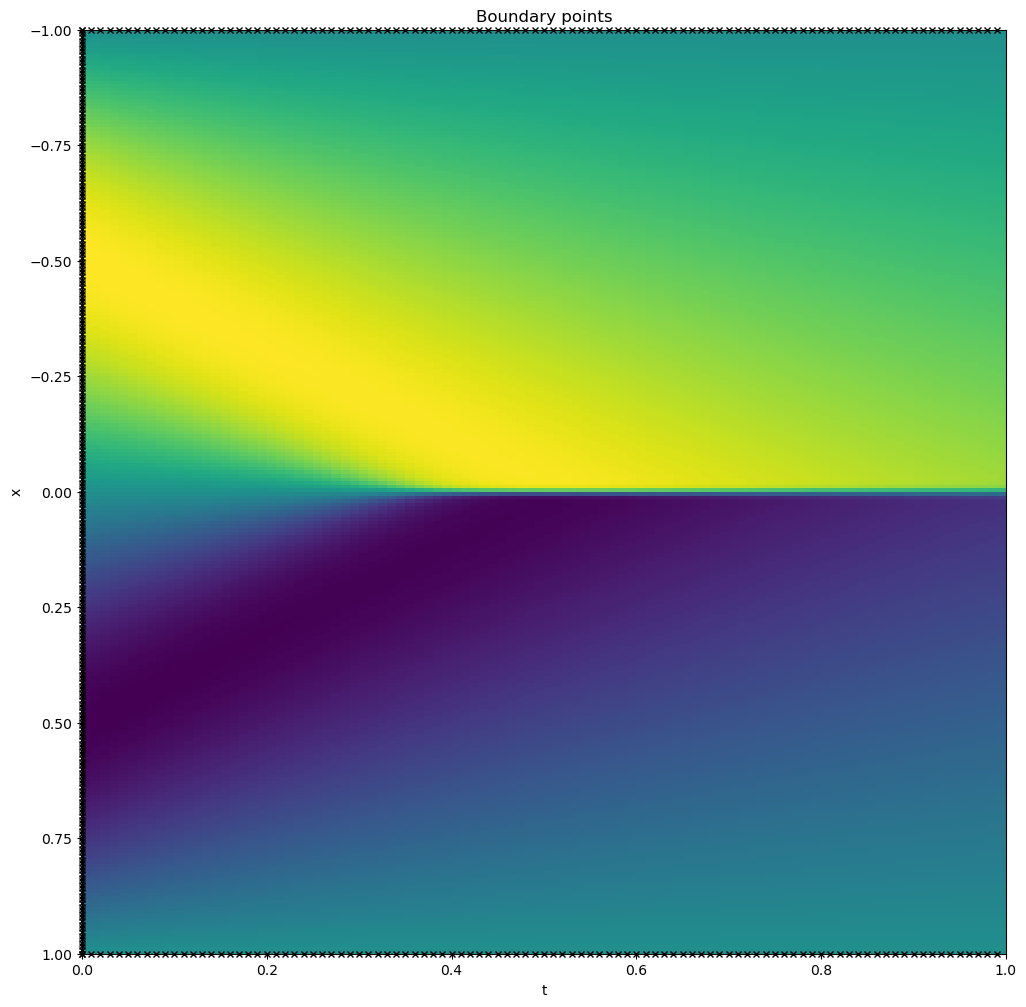

In [8]:
fig, ax = plt.subplots(1, figsize=(18, 12))
outimg = test_output.cpu().detach().numpy()
outimg = np.reshape(outimg, (xgridsize, tgridsize))

global_min = np.min([np.min(outimg), np.min(usol_full), np.min(np.abs(outimg - usol_full))])
global_max = np.max([np.max(outimg), np.max(usol_full), np.max(np.abs(outimg - usol_full))])

ax.set_title("Boundary points")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_box_aspect(1)
ax.imshow(outimg, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')
# ax.plot(ts.cpu().detach().numpy(), xs.cpu().detach().numpy(), 'kx', label = 'Data (%d points)' % 1, markersize = 4, clip_on = False)
ax.plot(tb.cpu().detach().numpy(), xb.cpu().detach().numpy(), 'kx', label = 'Data (%d points)' % 1, markersize = 4, clip_on = False)

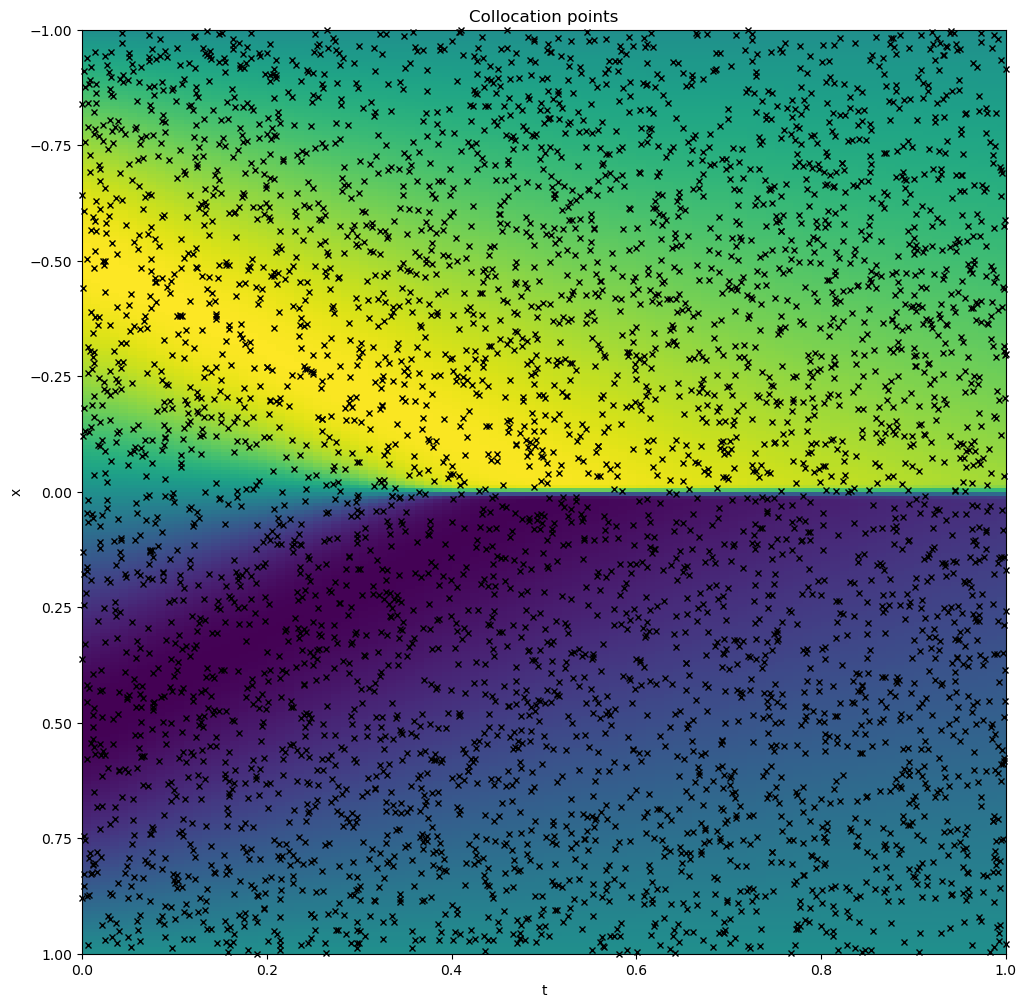

In [9]:
fig, ax = plt.subplots(1, figsize=(18, 12))
outimg = test_output.cpu().detach().numpy()
outimg = np.reshape(outimg, (xgridsize, tgridsize))

global_min = np.min([np.min(outimg), np.min(usol_full), np.min(np.abs(outimg - usol_full))])
global_max = np.max([np.max(outimg), np.max(usol_full), np.max(np.abs(outimg - usol_full))])

ax.set_title("Collocation points")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_box_aspect(1)
ax.imshow(outimg, vmin=global_min, vmax=global_max, extent=[0, 1, 1, -1], aspect='auto')
ax.plot(ts.cpu().detach().numpy(), xs.cpu().detach().numpy(), 'kx', label = 'Data (%d points)' % 1, markersize = 4, clip_on = False)
# ax.plot(tb.cpu().detach().numpy(), xb.cpu().detach().numpy(), 'kx', label = 'Data (%d points)' % 1, markersize = 4, clip_on = False)

### Loss

In [10]:
model.eval()

test_output = model(grid_points)
testu_t, testu_x, testu_xx = get_grads(test_output, xv, tv)
testres = testu_t + torch.flatten(test_output) * testu_x - 0.01 / np.pi * testu_xx

In [11]:
print("Test res", torch.norm(testres))

Test res tensor(2.0930, device='cuda:0', dtype=torch.float64, grad_fn=<CopyBackwards>)


### Difference

In [12]:
def evaluate2(iteration, model, xv, tv, test_usol, error):
    """Difference"""
    test_points = torch.stack((xv, tv)).transpose(0,1)
    pred_usol = model(test_points)
    L2_error = torch.norm(pred_usol - test_usol) ** 2 / pred_usol.numel()
    print(torch.norm(pred_usol.flatten() - test_usol) ** 2 / pred_usol.numel())


In [13]:
evaluate2(0, model, xv, tv, usol_tensor, error)

tensor(7.7745e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)


### Feasibility

In [14]:
xb, tb = boundary_points
xtb = torch.cat((xb, tb), 1)
ub = model(xtb)
torch.norm(ub - usolb).item()

8.249836635569e-06